# Melanoma Detection using Convolution Neural Networks

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data

Import libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Load the data by mounting the google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
basepath ='/content/gdrive/MyDrive/Melanoma_Detection'
data_dir_train= pathlib.Path(basepath + '/Train')
data_dir_test=pathlib.Path(basepath + '/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = 'validation',
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

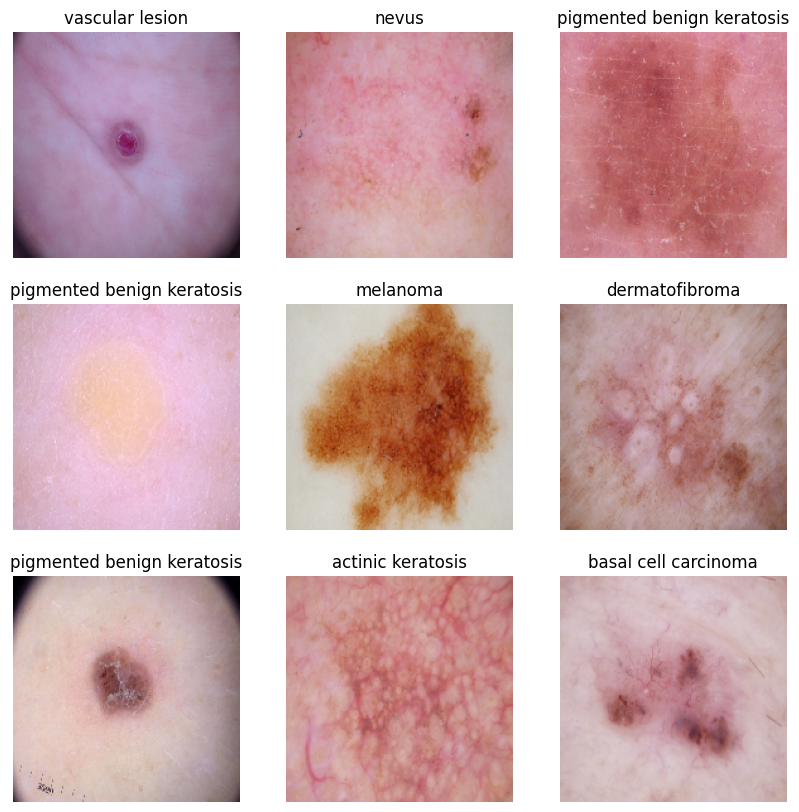

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
+ The model can accurately detect 9 classes present in the dataset using `layers.experimental.preprocessing`.
+ Rescaling to normalize pixel values between (0,1).
+ The RGB channel values are in the [0, 255] range which is not ideal for a neural network. Hence standardizing the values to be in the [0, 1] range.

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 422s 2s/step - loss: 2.0617 - accuracy: 0.2355 - val_loss: 1.9027 - val_accuracy: 0.3087
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7193 - accuracy: 0.3862 - val_loss: 1.7172 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6429 - accuracy: 0.4096 - val_loss: 1.5888 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4591 - accuracy: 0.4844 - val_loss: 1.5130 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3845 - accuracy: 0.5095 - val_loss: 1.4292 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2860 - accuracy: 0.5480 - val_loss: 1.3452 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2315 - accuracy: 0.5653 - val_loss: 1.3362 - val_accuracy: 0.5548
Epoch 8/20
56

### Visualizing training results

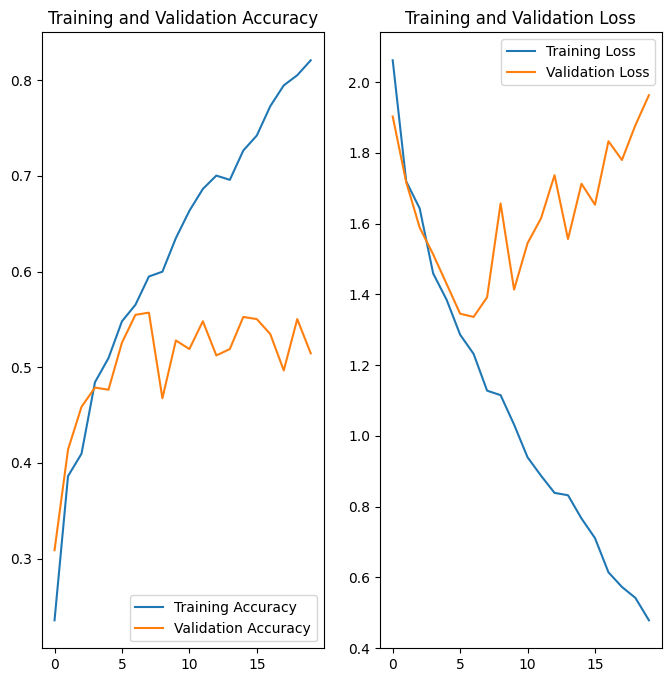

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
> + The above plot depicts that the model is over fitting.
> + It can be observed that the accuracy at epoch 20 is greater than 80% for training while it is close to 50% for Validation.

In [16]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

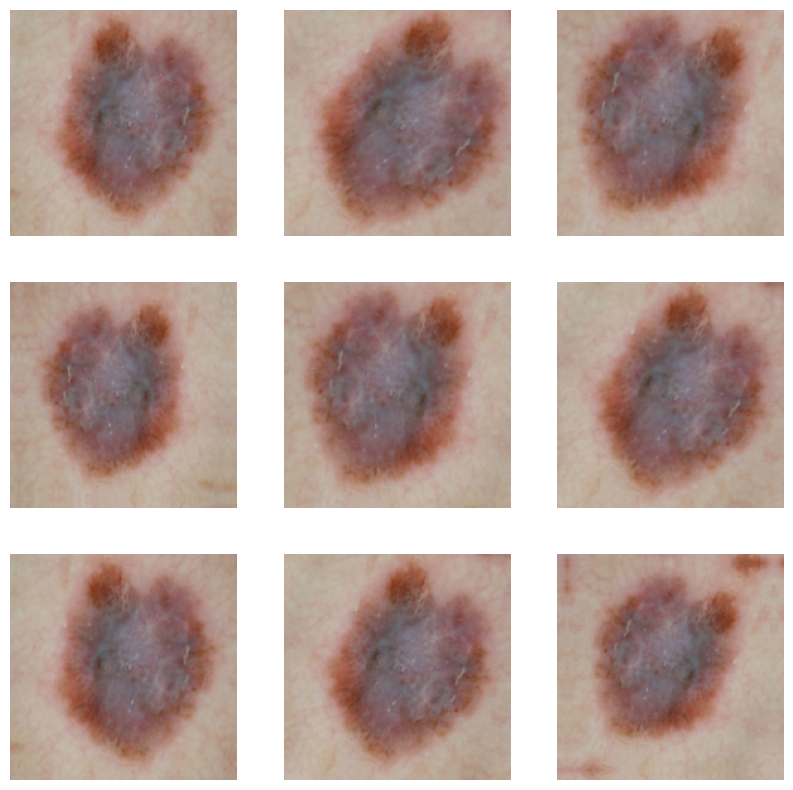

In [17]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [19]:
## Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 34ms/step - loss: 2.2061 - accuracy: 0.2042 - val_loss: 2.0210 - val_accuracy: 0.1969
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 2.0179 - accuracy: 0.2238 - val_loss: 1.9458 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8118 - accuracy: 0.3460 - val_loss: 1.8432 - val_accuracy: 0.3423
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6658 - accuracy: 0.4023 - val_loss: 1.4773 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4710 - accuracy: 0.4967 - val_loss: 1.4047 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4309 - accuracy: 0.5045 - val_loss: 1.4460 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4023 - accuracy: 0.5162 - val_loss: 1.5823 - val_accuracy: 0.4474
Epoch 8/20
56

### Visualizing the results

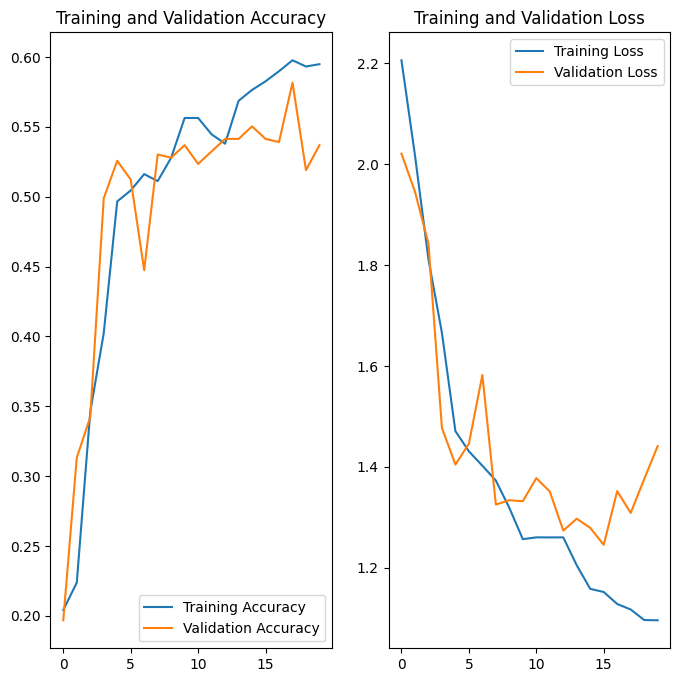

In [21]:
## Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. On implementation of data agumentation step, the difference in training and validation accuracy is significantly reduced.
2. The model fits comparitively better to previos model.
3. The model can be further improved to increase the accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [23]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,vascular lesion
1,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,vascular lesion
2,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,vascular lesion
3,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,vascular lesion
4,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,vascular lesion
...,...,...
2234,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,melanoma
2235,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,melanoma
2236,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,melanoma
2237,/content/gdrive/MyDrive/Melanoma_Detection/Tra...,melanoma


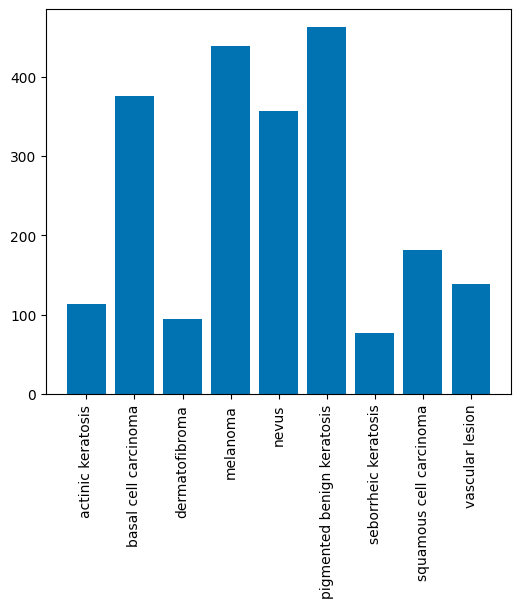

In [31]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns


# plot the distribution
# Assign figure size and color palette
plt.figure(figsize=[6,5])
# sns.set_style("white")
# sns.set_style("whitegrid")
# sns.set_style("darkgrid")
sns.set_palette(palette = 'colorblind', n_colors = 10, desat = None)
current_palette = sns.color_palette()
base_color = sns.color_palette()[7]

count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.bar(class_names,count)
plt.xticks(rotation=90)
plt.show();

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
+ `Seborrheic Keratosi`s class has the least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?
+ `Pigmented Benign Keratosis` dominate the data in terms proportionate number of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset=basepath + '/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B99D01A2B00>: 100%|██████████| 500/500 [00:21<00:00, 23.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B994F956740>: 100%|██████████| 500/500 [00:20<00:00, 24.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B994EDA69B0>: 100%|██████████| 500/500 [00:19<00:00, 25.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7B994FEAD210>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B99D009BD00>: 100%|██████████| 500/500 [01:18<00:00,  6.35 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B9A8136F1C0>: 100%|██████████| 500/500 [00:20<00:00, 24.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B994FEAD750>: 100%|██████████| 500/500 [00:43<00:00, 11.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B9970708E80>: 100%|██████████| 500/500 [00:20<00:00, 24.49 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B994EDD1FF0>: 100%|██████████| 500/500 [00:23<00:00, 21.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Melanoma_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0027937.jpg_dee2fc56-4ec8-4022-89fa-a1ef200aa3c4.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0033991.jpg_2ec08f7c-ce8e-4424-8907-925c23f5c94a.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_754fbeaf-58ec-42a3-aa23-6d63e6f2c258.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0025628.jpg_e3051140-2732-4757-83aa-5b4e3bc38710.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0025873.jpg_714028c0-7895-4341-9690-88be1c9a2d71.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0027790.jpg_65b360e7-2ba9-4f44-bbab-cd29f062bedb.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection/T

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [39]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [42]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 50s 85ms/step - loss: 1.9078 - accuracy: 0.2763 - val_loss: 1.6560 - val_accuracy: 0.4024
Epoch 2/20
169/169 [==============================] - 4s 27ms/step - loss: 1.4389 - accuracy: 0.4644 - val_loss: 1.2692 - val_accuracy: 0.5516
Epoch 3/20
169/169 [==============================] - 4s 26ms/step - loss: 1.2478 - accuracy: 0.5402 - val_loss: 1.2179 - val_accuracy: 0.5605
Epoch 4/20
169/169 [==============================] - 5s 28ms/step - loss: 1.0563 - accuracy: 0.6193 - val_loss: 1.0661 - val_accuracy: 0.6251
Epoch 5/20
169/169 [==============================] - 4s 26ms/step - loss: 0.8766 - accuracy: 0.6901 - val_loss: 0.9304 - val_accuracy: 0.6771
Epoch 6/20
169/169 [==============================] - 4s 26ms/step - loss: 0.7096 - accuracy: 0.7533 - val_loss: 0.9505 - val_accuracy: 0.6964
Epoch 7/20
169/169 [==============================] - 5s 28ms/step - loss: 0.6034 - accuracy: 0.7858 - val_loss: 0.8614 - val_accuracy: 0.7030
Epoch 8/2

#### **Todo:**  Visualize the model results

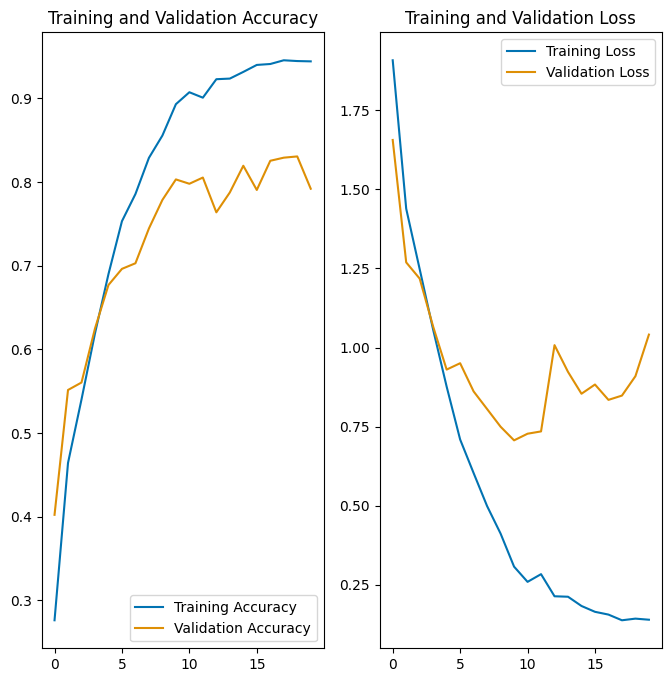

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Key Findings:**
> + The above plot depicts that the overfitting problem has been significantly reduced.
> + Class rebalance and agumentor techniques contributed to resolving the overfitting problem.
> +  Hyperparameter tuning can be leveraged to further improve the model.

-------